# Mass Transfer (MT) COMSOL Post-Processing
Apr 2nd, 2025
Data analysis by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_123 = pd.read_csv("data/123_data_conc.csv")
df_128 = pd.read_csv("data/128_data_conc.csv")
df_133 = pd.read_csv("data/133_data_conc.csv")
df_140 = pd.read_csv("data/140_data_conc.csv")

df_123_flux = pd.read_csv("data/123-flux-data.csv")
df_128_flux = pd.read_csv("data/128-flux-data.csv")
df_133_flux = pd.read_csv("data/133-flux-data.csv")
df_140_flux = pd.read_csv("data/140-flux-data.csv")

df_1_0 = pd.read_csv("data/1ms-data.csv")
df_1_1 = pd.read_csv("data/1.1ms-data.csv")
df_1_4 = pd.read_csv("data/1.4ms-data.csv")
df_1_5 = pd.read_csv("data/1.5ms-data.csv")


df_mass = pd.read_csv("data/mass_data_processed.csv")
df_tc = pd.read_csv("data/tc_data_processed.csv")
df_ane = pd.read_csv("data/anemometer_data_processed.csv")

## Pre-Processing

In [4]:
MW = 18.01528 # g / mol

df_123["c_mass"] = df_123["c"] * MW / 1000
df_128["c_mass"] = df_128["c"] * MW / 1000
df_133["c_mass"] = df_133["c"] * MW / 1000
df_140["c_mass"] = df_140["c"] * MW / 1000

df_123_flux["c_mass"] = df_123["c"] * MW / 1000
df_128_flux["c_mass"] = df_128["c"] * MW / 1000
df_133_flux["c_mass"] = df_133["c"] * MW / 1000
df_140_flux["c_mass"] = df_140["c"] * MW / 1000

df_1_0["c_mass"] = df_1_0["c"] * MW / 1000
df_1_1["c_mass"] = df_1_1["c"] * MW / 1000
df_1_4["c_mass"] = df_1_4["c"] * MW / 1000
df_1_5["c_mass"] = df_1_5["c"] * MW / 1000


In [5]:
df_ane = df_ane.dropna().reset_index()

In [6]:
df_ane

,index,heater_temp,distance,relative_humidity,air_velocity,temperature_ane
0,0,140,4,25.3,420.0,84.2
1,2,140,12,25.3,322.0,84.2
2,4,140,20,25.3,410.0,84.2
3,5,133,4,27.7,250.0,81.2
4,7,133,12,27.7,190.0,81.2
5,9,133,20,27.7,334.0,81.2
6,10,128,4,30.4,204.0,77.4
7,12,128,12,30.4,227.0,77.4
8,14,128,20,30.4,295.0,77.4
9,15,123,4,33.4,155.0,74.4


In [7]:
df_ane["air_velocity_ms"] = df_ane["air_velocity"] * 0.00508
df_ane["avg_velocity_ms"] = df_ane.groupby("heater_temp")["air_velocity_ms"].transform("mean")

In [8]:
df_123_flux["mass_flux"] = df_123_flux["mol_flux"] * MW / 1000 # kg / m^2 s
df_128_flux["mass_flux"] = df_128_flux["mol_flux"] * MW / 1000 # kg / m^2 s
df_133_flux["mass_flux"] = df_133_flux["mol_flux"] * MW / 1000 # kg / m^2 s
df_140_flux["mass_flux"] = df_140_flux["mol_flux"] * MW / 1000 # kg / m^2 s

In [9]:
L = 0.555 # m
W = 0.200 # m
area = L * W # m^2

P = 101325 # Pa
P_atm = 1 # atm
D_AB = 2.634 / P # m^2 / s
R = 8.314 # J / mol K

## Question 2:
Determine the thicknesses of both thermal and concentration boundary layers and how they
vary with position x (at a fixed velocity) as well as with velocity (at a fixed position or
average along various positions). Clearly describe how you determine the boundary-layer
thickness. Explain the trends and what you expect based on theory, and the physical
reasoning of such trends. Please avoid nonlinear fits (because in general they do not
guarantee a unique solution and can be difficult to judge visually because subtleties in
curvature can be unobvious) and instead linearize your equations so as to enable use of
linear least-squares regression (which has a unique solution and is intuitive to judge
visually).

For thermal boundary layer, we can use:
$$
\delta_{t} = \frac{T_{bulk} - T_0}{(\frac{dT}{dz})_{z=0}}
$$

This approach will be similar to experimental analysis, however, we will use average temperatures and temperature gradients from simulation results here.

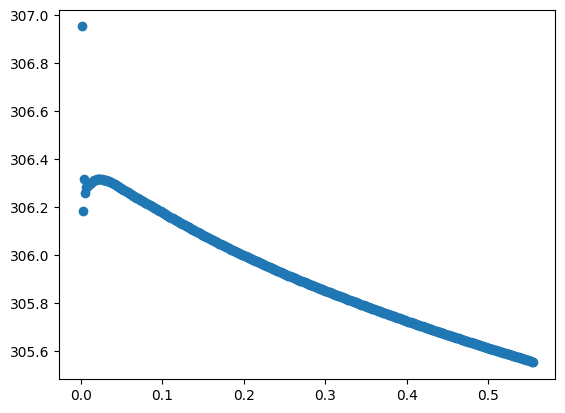

In [10]:
plt.scatter(df_123.query("y == 0 and x > 0")["x"], df_123.query("y == 0 and x > 0")["T"])

These boundary layer thicknesses are too large to be sensible so we will try a different approach. We will count any temperature above the interface where 99% of the bulk temperature is reached.

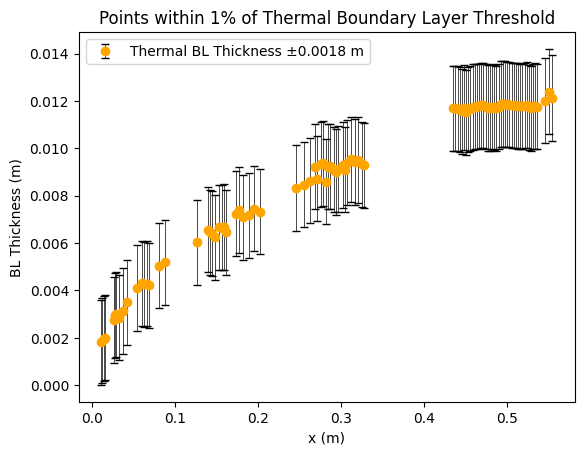

In [11]:
def get_T_BL_thickness(df):
    T_max = df["T"].max()
    T_min = df["T"].min()
    delta_T = T_max - T_min
    T_threshold = T_min + 0.99 * delta_T
    T_lower_bound = T_threshold - 0.01 * delta_T

    filtered_df = df[(df["T"] >= T_lower_bound) & (df["T"] <= T_threshold)]
    return filtered_df["x"], filtered_df["y"], filtered_df["T"]

BL_thermal_123_x, BL_thermal_123_y, _ = get_T_BL_thickness(df_123)

y_error_thermal = np.full_like(BL_thermal_123_y, 0.0018)
plt.errorbar(BL_thermal_123_x, BL_thermal_123_y, yerr=y_error_thermal, fmt='o', color="orange",
             ecolor='black', capsize=3, linewidth = 0.5, label="Thermal BL Thickness ±0.0018 m")
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Points within 1% of Thermal Boundary Layer Threshold")
plt.legend()
plt.show()

This gives us all data within 1% of the 99% threshold. We will now take these values and plot them as log-log to obtain a linear fit, which will give us our scaling factor.

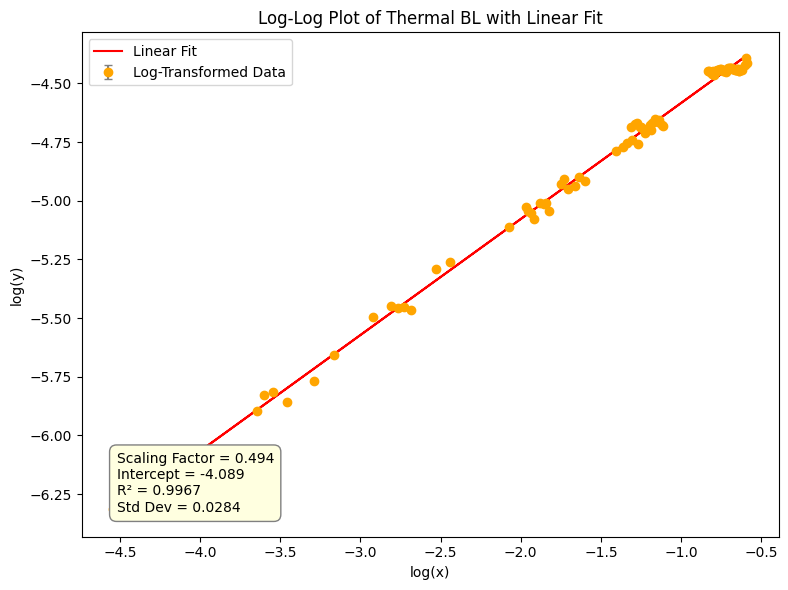

In [12]:
mask = (BL_thermal_123_x > 0) & (BL_thermal_123_y > 0)
x_log = np.log(BL_thermal_123_x[mask])
y_log = np.log(BL_thermal_123_y[mask])

log_y_error = y_error_thermal / abs(y_log)

slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
y_fit = slope * x_log + intercept

residuals = y_log - y_fit
std_dev = np.std(residuals)

plt.figure(figsize=(8, 6))
plt.errorbar(x_log, y_log, yerr=log_y_error, fmt='o', color="orange",
             ecolor='gray', capsize=3, label="Log-Transformed Data")
plt.plot(x_log, y_fit, color="red", label="Linear Fit")

annotation = (f"Scaling Factor = {slope:.3f}\n"
              f"Intercept = {intercept:.3f}\n"
              f"R² = {r_value**2:.4f}\n"
              f"Std Dev = {std_dev:.4f}")
plt.annotate(annotation, xy=(0.05, 0.05), xycoords="axes fraction",
             fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="gray"))

plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.title("Log-Log Plot of Thermal BL with Linear Fit")
plt.legend()
plt.tight_layout()
plt.show()

Note: error of log-log data is too small to be shown on plot

We will get concentration by determining the height above the interface where 90% of the bulk concentration is reached

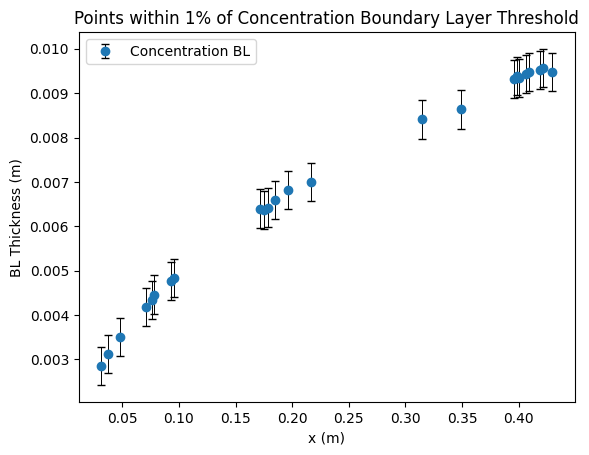

In [13]:
def get_c_BL_thickness(df):
    c_max = df["c"].max()
    c_min = df["c"].min()
    delta_c = c_max - c_min
    c_threshold = c_min + (0.1 * delta_c)
    c_lower_bound = c_threshold - 0.01 * delta_c

    filtered_df = df[(df["c"] >= c_lower_bound) & (df["c"] <= c_threshold)]
    return filtered_df["x"], filtered_df["y"], filtered_df["c_mass"]

BL_concentration_123_x, BL_concentration_123_y, BL_concentration_123_c = get_c_BL_thickness(df_123)

y_error = np.full_like(BL_concentration_123_y, 0.00043)

plt.errorbar(BL_concentration_123_x, BL_concentration_123_y, yerr=y_error, fmt='o',
             ecolor='black', capsize=3, linewidth=0.7, label="Concentration BL")

plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Points within 1% of Concentration Boundary Layer Threshold")
plt.legend()
plt.show()


Plotting log-log values to determine concentration BL scaling factor

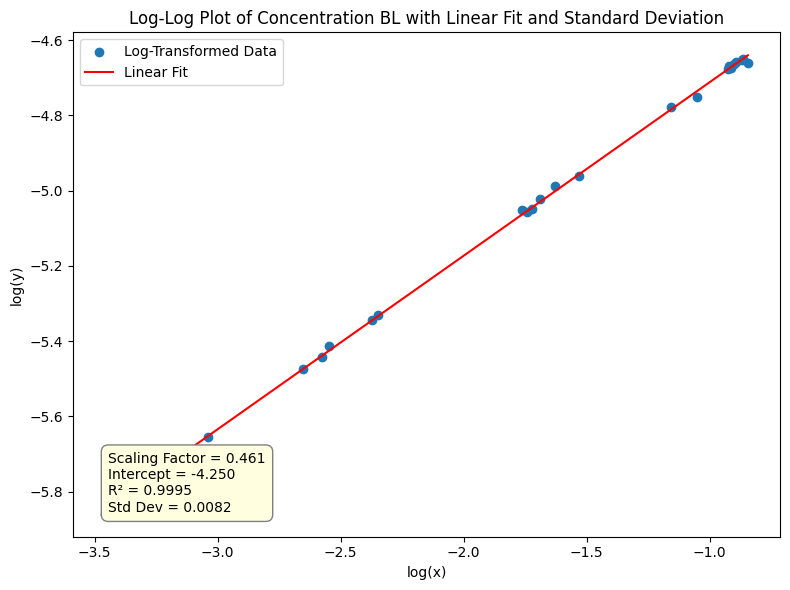

In [14]:
mask1 = (BL_concentration_123_x > 0) & (BL_concentration_123_y > 0)
x_log = np.log(BL_concentration_123_x[mask1])
y_log = np.log(BL_concentration_123_y[mask1])

slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)
y_fit = slope * x_log + intercept

residuals = y_log - y_fit
std_dev = np.std(residuals)

plt.figure(figsize=(8, 6))
plt.scatter(x_log, y_log, label="Log-Transformed Data")
plt.plot(x_log, y_fit, color="red", label="Linear Fit")

annotation = (f"Scaling Factor = {slope:.3f}\n"
              f"Intercept = {intercept:.3f}\n"
              f"R² = {r_value**2:.4f}\n"
              f"Std Dev = {std_dev:.4f}")
plt.annotate(annotation, xy=(0.05, 0.05), xycoords="axes fraction",
             fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="gray"))

plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.title("Log-Log Plot of Concentration BL with Linear Fit and Standard Deviation")
plt.legend()
plt.tight_layout()
plt.show()

Now that we have calculated the boundary layer thicknesses, let's visually check that they are correct by overlaying the plots:

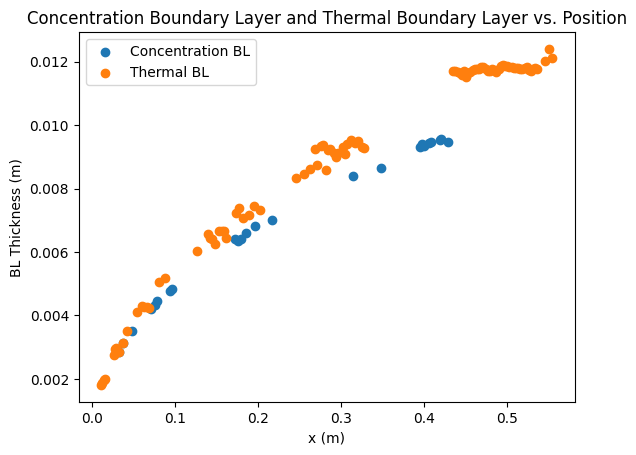

In [15]:
plt.scatter(BL_concentration_123_x, BL_concentration_123_y)
plt.scatter(BL_thermal_123_x, BL_thermal_123_y)
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Concentration Boundary Layer and Thermal Boundary Layer vs. Position")
plt.legend(["Concentration BL", "Thermal BL"])
plt.show()

We can now see that the thermal boundary layer is consistently thicker than the concentration boundary layer, and that the thermal boundary layer scales more with position along the tray

In [16]:
BL_thermal_128_x, BL_thermal_128_y, _ = get_T_BL_thickness(df_128)
BL_thermal_133_x, BL_thermal_133_y, _ = get_T_BL_thickness(df_133)
BL_thermal_140_x, BL_thermal_140_y, _ = get_T_BL_thickness(df_140)

BL_concentration_128_x, BL_concentration_128_y, BL_concentration_128_c = get_c_BL_thickness(df_128)
BL_concentration_133_x, BL_concentration_133_y, BL_concentration_133_c = get_c_BL_thickness(df_133)
BL_concentration_140_x, BL_concentration_140_y, BL_concentration_140_c = get_c_BL_thickness(df_140)

Creating plot of thermal BLs across all air velocities:

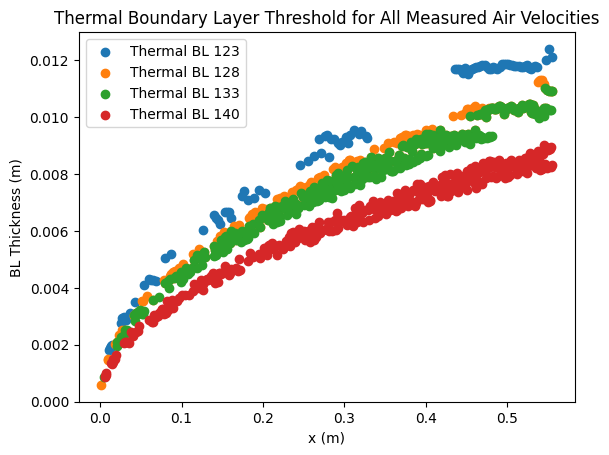

In [17]:
plt.scatter(BL_thermal_123_x, BL_thermal_123_y)
plt.scatter(BL_thermal_128_x, BL_thermal_128_y)
plt.scatter(BL_thermal_133_x, BL_thermal_133_y)
plt.scatter(BL_thermal_140_x, BL_thermal_140_y)
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Thermal Boundary Layer Threshold for All Measured Air Velocities")
plt.legend(["Thermal BL 123", "Thermal BL 128", "Thermal BL 133", "Thermal BL 140"])
plt.show()

Calculating average thermal BL thickness at narrow range of X-values (0.25-0.32):

In [18]:
# this is to narrow the range of x values that are considered when calculating our average BL thickness
# since we don't have an x value that contains data for all of the air speeds
lower_bound = 0.25
upper_bound = 0.32
filter_for_thermal_BL_123 = (BL_thermal_123_x >= lower_bound) & (BL_thermal_123_x <= upper_bound)
filter_for_thermal_BL_128 = (BL_thermal_128_x >= lower_bound) & (BL_thermal_128_x <= upper_bound)
filter_for_thermal_BL_133 = (BL_thermal_133_x >= lower_bound) & (BL_thermal_133_x <= upper_bound)
filter_for_thermal_BL_140 = (BL_thermal_140_x >= lower_bound) & (BL_thermal_140_x <= upper_bound)

avg_thermal_BL_123 = BL_thermal_123_y[filter_for_thermal_BL_123].mean()
avg_thermal_BL_128 = BL_thermal_128_y[filter_for_thermal_BL_128].mean()
avg_thermal_BL_133 = BL_thermal_133_y[filter_for_thermal_BL_133].mean()
avg_thermal_BL_140 = BL_thermal_140_y[filter_for_thermal_BL_140].mean()

print("Average thermal Boundary Layer for 123ºF =", avg_thermal_BL_123)
print("Average thermal Boundary Layer for 128ºF =", avg_thermal_BL_128)
print("Average thermal Boundary Layer for 133ºF =", avg_thermal_BL_133)
print("Average thermal Boundary Layer for 140ºF =", avg_thermal_BL_140)

Average thermal Boundary Layer for 123ºF = 0.009105356320915149
Average thermal Boundary Layer for 128ºF = 0.007851251865776388
Average thermal Boundary Layer for 133ºF = 0.007573749988846263
Average thermal Boundary Layer for 140ºF = 0.006195004269611533


Creating plot of concentration BLs across all air velocties

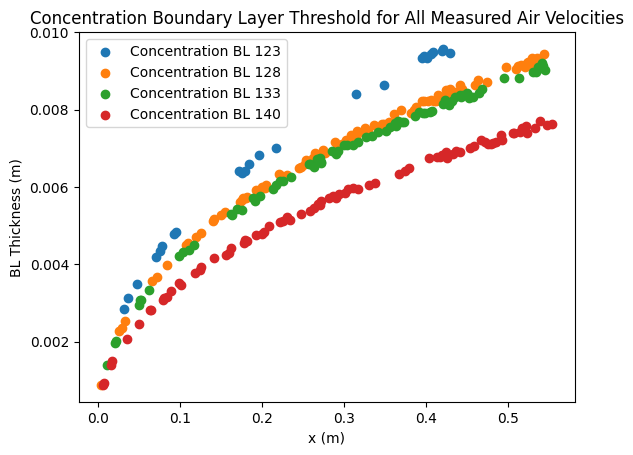

In [19]:
plt.scatter(BL_concentration_123_x, BL_concentration_123_y)
plt.scatter(BL_concentration_128_x, BL_concentration_128_y)
plt.scatter(BL_concentration_133_x, BL_concentration_133_y)
plt.scatter(BL_concentration_140_x, BL_concentration_140_y)
plt.xlabel("x (m)")
plt.ylabel("BL Thickness (m)")
plt.title("Concentration Boundary Layer Threshold for All Measured Air Velocities")
plt.legend(["Concentration BL 123", "Concentration BL 128", "Concentration BL 133", "Concentration BL 140"])
plt.show()

Comparing mean concentration BL thicknesses for narrow range of x-values (0.25-0.32)

In [20]:
# this is to narrow the range of x values that are considered when calculating our average BL thickness
# since we don't have an x value that contains data for all of the air speeds
lower_bound1 = 0.25
upper_bound1 = 0.32
filter_for_concentration_BL_123 = (BL_concentration_123_x >= lower_bound1) & (BL_concentration_123_x <= upper_bound1)
filter_for_concentration_BL_128 = (BL_concentration_128_x >= lower_bound1) & (BL_concentration_128_x <= upper_bound1)
filter_for_concentration_BL_133 = (BL_concentration_133_x >= lower_bound1) & (BL_concentration_133_x <= upper_bound1)
filter_for_concentration_BL_140 = (BL_concentration_140_x >= lower_bound1) & (BL_concentration_140_x <= upper_bound1)

avg_concentration_BL_123 = BL_concentration_123_y[filter_for_concentration_BL_123].mean()
avg_concentration_BL_128 = BL_concentration_128_y[filter_for_concentration_BL_128].mean()
avg_concentration_BL_133 = BL_concentration_133_y[filter_for_concentration_BL_133].mean()
avg_concentration_BL_140 = BL_concentration_140_y[filter_for_concentration_BL_140].mean()

print("Average concentration Boundary Layer for 123ºF =", avg_concentration_BL_123)
print("Average concentration Boundary Layer for 128ºF =", avg_concentration_BL_128)
print("Average concentration Boundary Layer for 133ºF =", avg_concentration_BL_133)
print("Average concentration Boundary Layer for 140ºF =", avg_concentration_BL_140)

Average concentration Boundary Layer for 123ºF = 0.0084069051769559
Average concentration Boundary Layer for 128ºF = 0.007040258478087815
Average concentration Boundary Layer for 133ºF = 0.006826124008886272
Average concentration Boundary Layer for 140ºF = 0.005712464859577169


Deterimining how boundary layer thickness scales with air velocity

In [21]:
flux_data = [-0.0017986, -0.0019379, -0.0020889, -0.0019698]
mflux_df = pd.DataFrame(flux_data, columns=["molar flux"])
mflux_df['air velocity (m/s)'] = [1.95072, 1.31064, 1.22936, 0.91948]
COMSOL_para = mflux_df
COMSOL_para

,molar flux,air velocity (m/s)
0,-0.001799,1.95072
1,-0.001938,1.31064
2,-0.002089,1.22936
3,-0.001970,0.91948


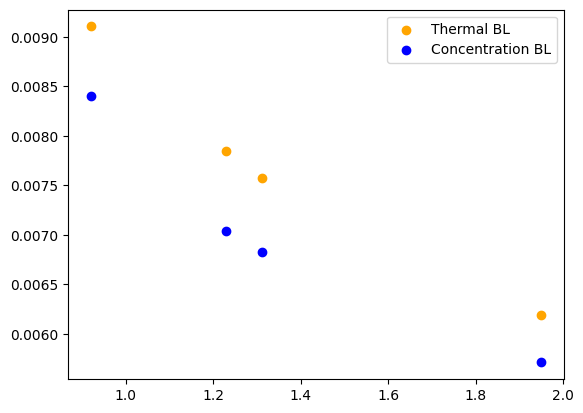

In [22]:
air_velocities = COMSOL_para['air velocity (m/s)'][::-1]
conc_BLs = [avg_concentration_BL_123, avg_concentration_BL_128, avg_concentration_BL_133, avg_concentration_BL_140]
thermal_BLs = [avg_thermal_BL_123, avg_thermal_BL_128, avg_thermal_BL_133, avg_thermal_BL_140]
plt.scatter(air_velocities, thermal_BLs, color="orange", label="Thermal BL")
plt.scatter(air_velocities, conc_BLs, color="blue", label="Concentration BL")
plt.legend()

Slope: -0.5122 ± 0.0033
Intercept: -2.0596
R-squared: 0.9999
p-value: 4.1634e-05
Slope: -0.5084 ± 0.0357
Intercept: -2.1006
R-squared: 0.9902
p-value: 4.8947e-03


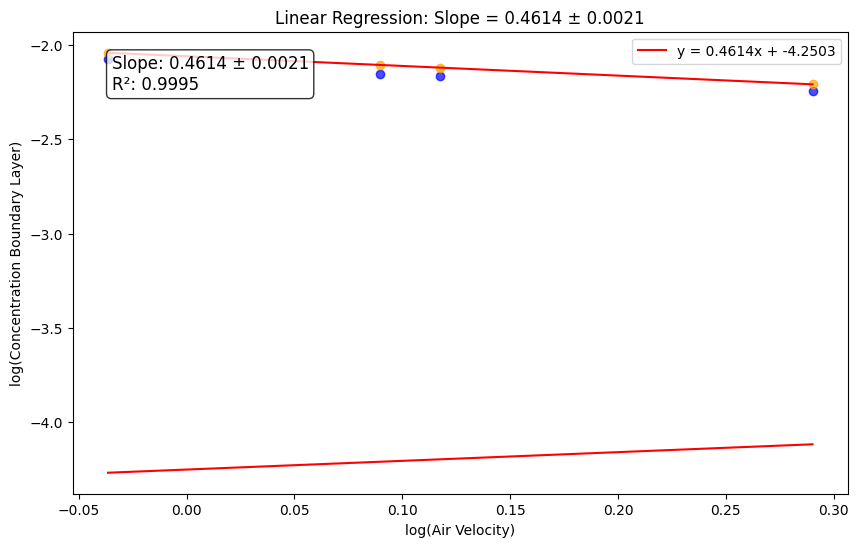

In [23]:
log_thermal_BL = np.log10(thermal_BLs)
log_conc_BL = np.log10(conc_BLs)
log_air_velocity = np.log10(air_velocities)

# Create plot
plt.figure(figsize=(10, 6))
plt.scatter(log_air_velocity, log_conc_BL, color='blue', alpha=0.7)
plt.plot(log_air_velocity, intercept + slope*log_air_velocity, 'r-', 
         label=f'y = {slope:.4f}x + {intercept:.4f}')

# Customize plot
plt.xlabel('log(Air Velocity)')
plt.ylabel('log(Concentration Boundary Layer)')
plt.title(f'Linear Regression: Slope = {slope:.4f} ± {std_err:.4f}')
plt.legend()

# Optional: Add text with regression statistics on the plot
plt.text(0.05, 0.95, f'Slope: {slope:.4f} ± {std_err:.4f}\nR²: {r_value**2:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


slope, intercept, r_value, p_value, std_err = linregress(log_air_velocity, log_thermal_BL)

# Print results
print(f"Slope: {slope:.4f} ± {std_err:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4e}")

# Create plot
plt.scatter(log_air_velocity, log_thermal_BL, color='orange', alpha=0.7)
plt.plot(log_air_velocity, intercept + slope*log_air_velocity, 'r-', 
         label=f'y = {slope:.4f}x + {intercept:.4f}')
slope, intercept, r_value, p_value, std_err = linregress(log_air_velocity, log_conc_BL)

# Print results
print(f"Slope: {slope:.4f} ± {std_err:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4e}")

## Question 3
Calculate the mass transfer coefficient km as a function of the distance along the water tray
for one of the inlet velocities studied in the experiment. As mentioned in Eq. (4), the ratio
of mass flux to concentration difference driving force defines the mass transfer coefficient.
Explain the trend and what you expect based on theory, and the physical reasoning of such
trends. Here again avoid nonlinear fits and instead linearize your equations so as to enable
use of linear least-squares regression.

From our COMSOL analysis, we have $N_A$ as mass flux to get $k_m$ as:

$$
k_m (x) = \frac{N_A}{c_0- c_{bulk}(x) } 
$$

So our first step is to get $c_0 (x)$

In [24]:
df_123

,x,y,T,c,c_mass
0,0.000000,0.001165,316.538890,0.000000,0.000000
1,0.000000,0.000547,316.538890,0.000000,0.000000
2,0.000889,0.000946,316.531245,0.000914,0.000016
3,0.001411,0.001557,316.537820,0.000152,0.000003
4,0.000000,0.002294,316.538890,0.000000,0.000000
...,...,...,...,...,...
4336,0.552319,0.000000,305.560707,0.361000,0.006504
4337,0.553659,0.000261,306.025291,0.350691,0.006318
4338,0.555000,0.000261,306.024281,0.350287,0.006311
4339,0.553659,0.000000,305.556929,0.361000,0.006504


In [25]:
def get_c_BL_thickness(df):
    c_max = df["c"].max()
    c_min = df["c"].min()
    delta_c = c_max - c_min
    c_threshold = c_min + (0.10 * delta_c)
    c_lower_bound = c_threshold - 0.01 * delta_c

    filtered_df = df[(df["c"] >= c_lower_bound) & (df["c"] <= c_threshold)]
    return filtered_df["x"], filtered_df["y"], filtered_df["c_mass"]

BL_concentration_123_x, BL_concentration_123_y, BL_concentration_123_c = get_c_BL_thickness(df_123)

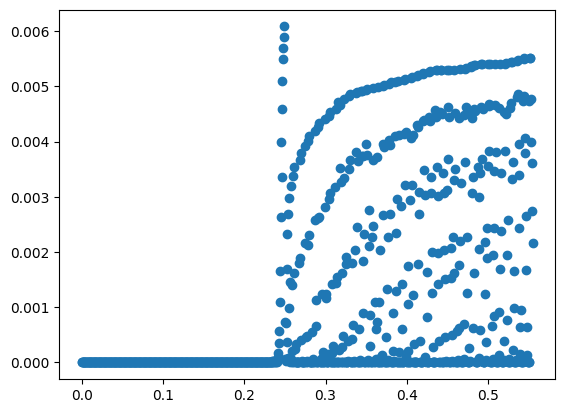

In [26]:
plt.scatter(df_123_flux.query("y == 0")["x"], df_123_flux.query("y == 0")["c_mass"])

In [27]:
# df_123_filtered = df_123.loc[df_123.groupby("x")["T"].idxmax()]
# df_123_flux_filtered = df_123_flux[df_123_flux["y"] == 0]

# df_128_filtered = df_128.loc[df_128.groupby("x")["T"].idxmax()]
# df_128_flux_filtered = df_128_flux[df_128_flux["y"] == 0]

# df_133_filtered = df_133.loc[df_133.groupby("x")["T"].idxmax()]
# df_133_flux_filtered = df_133_flux[df_133_flux["y"] == 0]

df_140_filtered = df_140.loc[df_140.groupby("x")["T"].idxmax()]
df_140_flux_filtered = df_140_flux[df_140_flux["y"] == 0]

In [28]:
merged_df = pd.merge(df_140_flux_filtered, df_140_filtered, on="x")
merged_df = merged_df.drop(columns=["y_y", "T_y", "y_x", "T_x"])
merged_df = merged_df.rename(columns={
    "c_x": "c_0",
    "c_y": "c_b",
    "c_mass_x": "c_mass_0",
    "c_mass_y": "c_mass_b"
})
merged_df

,x,c_0,mol_flux,c_mass_0,mass_flux,c_b,c_mass_b
0,0.000000,0.1165,-0.024828,0.000000e+00,-0.000447,0.000000,0.000000e+00
1,0.000700,0.2330,-0.026502,1.845731e-08,-0.000477,0.011460,2.064513e-04
2,0.001400,0.2330,-0.018673,2.976479e-07,-0.000336,0.041345,7.448377e-04
3,0.002100,0.2330,-0.014541,0.000000e+00,-0.000262,0.067353,1.213384e-03
4,0.002799,0.2330,-0.012671,5.316336e-08,-0.000228,0.084988,1.531081e-03
...,...,...,...,...,...,...,...
789,0.552201,0.2330,-0.000955,1.663677e-08,-0.000017,0.220864,3.978926e-03
790,0.552900,0.2330,-0.000954,8.826484e-09,-0.000017,0.221473,3.989901e-03
791,0.553600,0.2330,-0.000953,1.546539e-08,-0.000017,0.222011,3.999596e-03
792,0.554300,0.2330,-0.000948,1.073258e-08,-0.000017,0.222276,4.004357e-03


In [29]:
def determine_mt_coeff(flux, c_0, c_b):
    return flux/(c_0 - c_b)

In [30]:
merged_df["mt_coeff"] = merged_df.apply(
    lambda row: determine_mt_coeff(row["mass_flux"], row["c_mass_0"], row["c_mass_b"]), axis=1
)
mt_df = merged_df
mt_df

,x,c_0,mol_flux,c_mass_0,mass_flux,c_b,c_mass_b,mt_coeff
0,0.000000,0.1165,-0.024828,0.000000e+00,-0.000447,0.000000,0.000000e+00,-inf
1,0.000700,0.2330,-0.026502,1.845731e-08,-0.000477,0.011460,2.064513e-04,2.312799
2,0.001400,0.2330,-0.018673,2.976479e-07,-0.000336,0.041345,7.448377e-04,0.451830
3,0.002100,0.2330,-0.014541,0.000000e+00,-0.000262,0.067353,1.213384e-03,0.215898
4,0.002799,0.2330,-0.012671,5.316336e-08,-0.000228,0.084988,1.531081e-03,0.149101
...,...,...,...,...,...,...,...,...
789,0.552201,0.2330,-0.000955,1.663677e-08,-0.000017,0.220864,3.978926e-03,0.004323
790,0.552900,0.2330,-0.000954,8.826484e-09,-0.000017,0.221473,3.989901e-03,0.004309
791,0.553600,0.2330,-0.000953,1.546539e-08,-0.000017,0.222011,3.999596e-03,0.004291
792,0.554300,0.2330,-0.000948,1.073258e-08,-0.000017,0.222276,4.004357e-03,0.004266


In [31]:
mt_df.replace([np.inf, -np.inf], 1, inplace=True)
mt_df_clean = mt_df[(mt_df["mt_coeff"] >= 0) & (mt_df["mt_coeff"] <= 1)]

In [32]:
mt_df_clean["mt_coeff"].min()

np.float64(0.0042664965929840384)

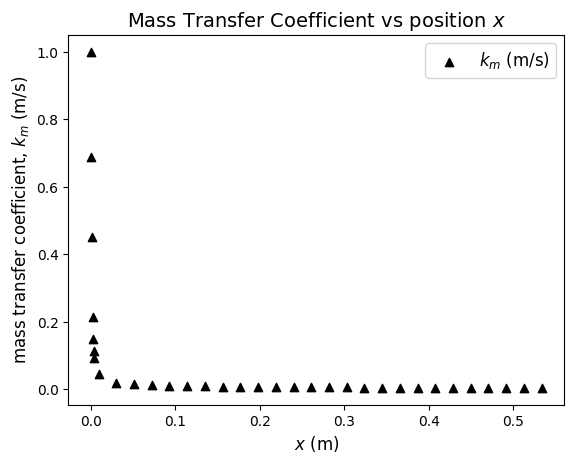

In [33]:
plt.scatter(mt_df_clean["x"][:6], mt_df_clean["mt_coeff"][:6], marker="^", color="black")
plt.scatter(mt_df_clean["x"][12::30], mt_df_clean["mt_coeff"][12::30], marker="^", color="black")
plt.scatter(0.00001, 0.69, marker="^", color="black")
plt.xlabel("$x$ (m)", fontsize=12)
plt.ylabel("mass transfer coefficient, $k_m$ (m/s)", fontsize=12)
plt.title("Mass Transfer Coefficient vs position $x$", fontsize=14)
plt.legend(["$k_m$ (m/s)"], fontsize=12)
plt.show()

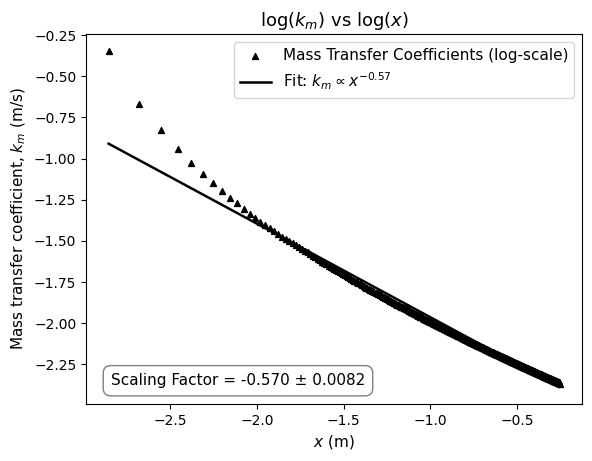

In [50]:
x_vals = mt_df_clean["x"]
km_vals = mt_df_clean["mt_coeff"]

mask = (x_vals > 0) & (km_vals > 0)
x_vals = x_vals[mask]
km_vals = km_vals[mask]

log_x = np.log10(x_vals)
log_km = np.log10(km_vals)

slope, intercept, r_value, *_ = linregress(log_x, log_km)
log_fit_km = slope*log_x+intercept

plt.figure()
plt.scatter(log_x, log_km, label="Mass Transfer Coefficients (log-scale)", color="black", marker="^", s=18)
plt.plot(log_x, log_fit_km, label=f"Fit: $k_m \\propto x^{{{slope:.2f}}}$", color ="black", linewidth=1.8)
plt.xlabel("$x$ (m)", fontsize=11)
plt.ylabel("Mass transfer coefficient, $k_m$ (m/s)", fontsize=11)
plt.title("log($k_m$) vs log($x$)", fontsize=13)
plt.legend(fontsize=11)
annotation = (f"Scaling Factor = {slope:.3f} ± {std_dev:.4f}")
plt.annotate(annotation, xy=(0.05, 0.05), xycoords="axes fraction",
             fontsize=11, color = "black", bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray"))
plt.show()

## Question 4
Compare the spatially-averaged values of km from the previous part to the values based on
the film theory, i.e., $k_m = D/\delta_c$. Compare both results with experimental measurements and
explain the cause of differences. Which one do you predict to be higher and why?

In [51]:
km_spatial_avg = mt_df_clean["mt_coeff"].mean()
km_spatial_avg

np.float64(0.010773716421454006)

In [36]:
print("Average thermal Boundary Layer for 123ºF =", avg_concentration_BL_123)
print("Average thermal Boundary Layer for 128ºF =", avg_concentration_BL_128)
print("Average thermal Boundary Layer for 133ºF =", avg_concentration_BL_133)
print("Average thermal Boundary Layer for 140ºF =", avg_concentration_BL_140)

Average thermal Boundary Layer for 123ºF = 0.0084069051769559
Average thermal Boundary Layer for 128ºF = 0.007040258478087815
Average thermal Boundary Layer for 133ºF = 0.006826124008886272
Average thermal Boundary Layer for 140ºF = 0.005712464859577169


In [37]:
km_film_123 = D_AB / avg_concentration_BL_123
km_film_128 = D_AB / avg_concentration_BL_128
km_film_133 = D_AB / avg_concentration_BL_133
km_film_140 = D_AB / avg_concentration_BL_140

In [38]:
print("Avg film theory mass transfer coefficient for 123ºF =", km_film_123)
print("Avg film theory mass transfer coefficient for 128ºF =", km_film_128)
print("Avg film theory mass transfer coefficient for 133ºF =", km_film_133)
print("Avg film theory mass transfer coefficient for 140ºF =", km_film_140)

Avg film theory mass transfer coefficient for 123ºF = 0.0030921674859086066
Avg film theory mass transfer coefficient for 128ºF = 0.0036924154029583807
Avg film theory mass transfer coefficient for 133ºF = 0.0038082459110702744
Avg film theory mass transfer coefficient for 140ºF = 0.0045506728678982086


In [48]:
print("Spatially averaged mass transfer coefficient for 123ºF =", km_spatial_avg)
print("Avg film theory mass transfer coefficient for 123ºF =", km_film_123)

Spatially averaged mass transfer coefficient for 123ºF = 0.010773716421454006
Avg film theory mass transfer coefficient for 123ºF = 0.0030921674859086066


## Question 5
Correlate the average value of km as a function of inlet velocity in the form of dimensionless
groups. In particular, $Sh = C_1 Re^{C_2} * Sc^{C_3} $. Specify the characteristic length and transport
properties used for calculating the dimensionless groups. Determine the value of C2 and
compare the result with experiment and with theory. Note that you have not conducted
experiments necessary to determine C1 or C3 independently, so focus only on C2. What
do you conclude about the flow in your system? In a separate plot, plot the average value
of km at a certain inlet velocity with the average boundary-layer thickness at that velocity,
for all velocities. Comment on what is physically driving the scaling of km with velocity.
Here again avoid nonlinear fits and instead linearize your equations so as to enable use of
linear least-squares regression.

In [40]:
L = 0.555  # m
D = 2.6e-5  # m²/s
rho = 1.2  # kg/m³
mu = 1.8e-5  # Pa·s (kg/m·s)

In [41]:
velocities = COMSOL_para["air velocity (m/s)"]

In [42]:
Re = rho * velocities * L / mu
Sc = mu / (rho * D)
Sh = km_vals * L / D

log_Re = np.log(Re)
log_Sh = np.log(Sh)

Using the data from the old csvs, we are going to plot log(Sh) and log(Re) to obtain the scaling factor

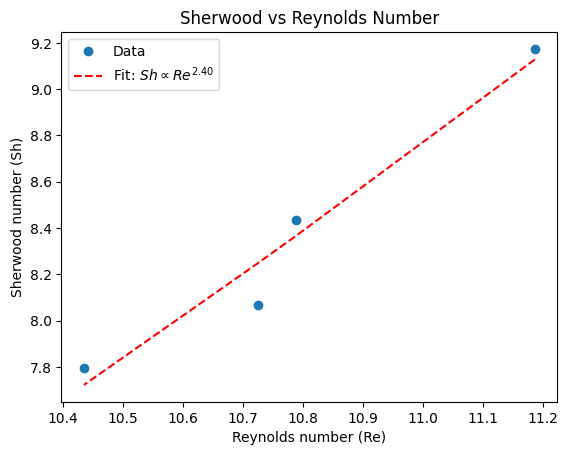

Fit: Sh ∝ Re^2.4044
Intercept (ln scale): -3.5945
R²: 0.9541
Standard error on slope: 0.0357


In [43]:
velocities = np.array([1.95072, 1.31064, 1.22936, 0.91948])
km_values_film = np.array([km_film_140, km_film_128, km_film_133, km_film_140])

Sh_filtered = log_Sh[:len(velocities)]
Re_filtered = log_Re[:len(velocities)]

slope, intercept, r_value, *_ = linregress(np.log(Re_filtered), np.log(Sh_filtered))
Sh_fit = np.exp(intercept) * Re_filtered**slope

plt.figure()
plt.plot(Re_filtered, Sh_filtered, 'o', label="Data")
plt.plot(Re_filtered, Sh_fit, 'r--', label=f"Fit: $Sh \\propto Re^{{{slope:.2f}}}$")
plt.xlabel("Reynolds number (Re)")
plt.ylabel("Sherwood number (Sh)")
plt.title("Sherwood vs Reynolds Number")
plt.legend()
plt.show()

print(f"Fit: Sh ∝ Re^{slope:.4f}")
print(f"Intercept (ln scale): {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"Standard error on slope: {std_err:.4f}")

Now that we have the new data, we can run the same computation for the 4 new csv files, combine them with the old data, and plot it all together to obtain an overall dimensionless correlation

In [44]:
# used the function we made earlier to get boundary layer thickness from new data
_, BL_y_1_0, _ = get_c_BL_thickness(df_1_0)
_, BL_y_1_1, _ = get_c_BL_thickness(df_1_1)
_, BL_y_1_4, _ = get_c_BL_thickness(df_1_4)
_, BL_y_1_5, _ = get_c_BL_thickness(df_1_5)

# get delta c and compute km for new data
delta_c_new = np.array([
    BL_y_1_0.mean(),
    BL_y_1_1.mean(),
    BL_y_1_4.mean(),
    BL_y_1_5.mean()
])
km_values_new = D / delta_c_new

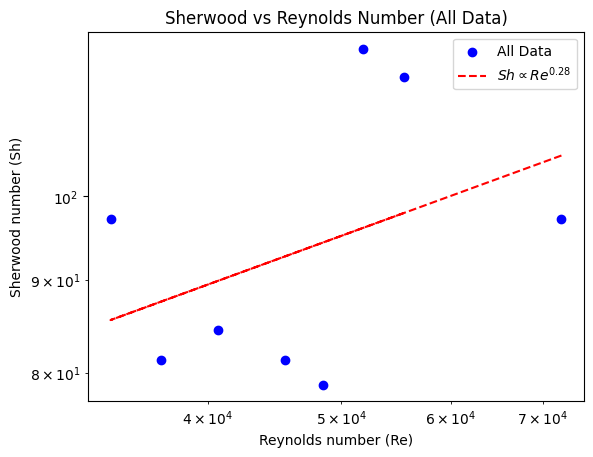

Fit: Sh ∝ Re^0.2764
Intercept (ln scale): 1.5648
R²: 0.1604
Standard error on slope: 0.2581


In [45]:
# combine all the data
# COMSOL flux csv velocities (old) i think
velocities_film = np.array([1.95072, 1.31064, 1.22936, 0.91948])
velocities_new = np.array([1.0, 1.1, 1.4, 1.5])
velocities_all = np.concatenate([velocities_film, velocities_new])
km_all = np.concatenate([km_values_film, km_values_new])

# recalculate Re and Sh for all data
Re_all = (rho * velocities_all * L) / mu
Sh_all = (km_all * L) / D
log_Re_all = np.log(Re_all)
log_Sh_all = np.log(Sh_all)

#linear regression for all data
slope, intercept, r_value, p_value, std_err = linregress(log_Re_all, log_Sh_all)
Sh_fit_all = np.exp(intercept) * Re_all**slope


plt.figure()
plt.scatter(Re_all, Sh_all, color='blue', label="All Data")
plt.plot(Re_all, Sh_fit_all, 'r--', label=f"$Sh \\propto Re^{{{slope:.2f}}}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reynolds number (Re)")
plt.ylabel("Sherwood number (Sh)")
plt.title("Sherwood vs Reynolds Number (All Data)")
plt.legend()
plt.show()
print(f"Fit: Sh ∝ Re^{slope:.4f}")
print(f"Intercept (ln scale): {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"Standard error on slope: {std_err:.4f}")

## Question 6
Compute the total evaporation rate and compare with the value you found experimentally.
Discuss whether they agree or not and the reasons. Discuss qualitatively the effect of
turbulence on km and boundary-layer thickness.

In [46]:
total_evap_rate_123 = df_123_flux["mass_flux"].mean() * area
total_evap_rate_128 = df_128_flux["mass_flux"].mean() * area
total_evap_rate_133 = df_133_flux["mass_flux"].mean() * area
total_evap_rate_140 = df_140_flux["mass_flux"].mean() * area

print(f"Total evaporation rate from COMSOL at 123°F: {abs(total_evap_rate_123):.6e} kg/s")
print(f"Total evaporation rate from COMSOL at 128°F: {abs(total_evap_rate_128):.6e} kg/s")
print(f"Total evaporation rate from COMSOL at 133°F: {abs(total_evap_rate_133):.6e} kg/s")
print(f"Total evaporation rate from COMSOL at 140°F: {abs(total_evap_rate_140):.6e} kg/s")


Total evaporation rate from COMSOL at 123°F: 3.189916e-06 kg/s
Total evaporation rate from COMSOL at 128°F: 3.374353e-06 kg/s
Total evaporation rate from COMSOL at 133°F: 3.132038e-06 kg/s
Total evaporation rate from COMSOL at 140°F: 2.323393e-06 kg/s
